In [3]:
import pandas as pd

In [4]:
# Load the data
df = pd.read_csv('data/prepared_data.csv')

# Select relevant columns
df = df[['cleaned_text', 'LabelMapped']]

In [5]:
df

,cleaned_text,LabelMapped
0,arrived broken manufacturer defect two of the ...,-1
1,the cabinet dot were all detached from backing...,-1
2,i received my first order of this product and ...,-1
3,this product is a piece of shit do not buy doe...,-1
4,went through in one day doesnt fit correct and...,-1
...,...,...
255077,racaltosk ok good to know punting at metlife i...,1
255078,everyone who sat around me at metlife was so a...,0
255079,what giants or niners fans would wanna go to t...,0
255080,anybody want a ticket for tomorrow colombia vs...,1


## common data preparation

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load the data
df = pd.read_csv('data/prepared_data.csv')

# Select relevant columns
df = df[['cleaned_text', 'LabelMapped']]

# Encode labels (convert -1 to 0, 0 to 1, 1 to 2)
df['LabelMapped'] = df['LabelMapped'].apply(lambda x: x + 1)

# Ensure labels are correctly transformed
print(df['LabelMapped'].unique())  # Should print [0, 1, 2]

# One-hot encode labels
labels = to_categorical(df['LabelMapped'], num_classes=3)

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_text'], labels, test_size=0.2, random_state=42
)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad the sequences
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert to numpy arrays
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


[0 1 2]


## CNN

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Define the CNN model
cnn_model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(24, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_history = cnn_model.fit(
    train_padded,
    train_labels,
    epochs=10,
    validation_data=(test_padded, test_labels),
    verbose=2
)

# Evaluate the model
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_padded, test_labels, verbose=2)
print(f'CNN Model - Loss: {cnn_loss}')
print(f'CNN Model - Accuracy: {cnn_accuracy}')


Epoch 1/10


/opt/conda/envs/dspt/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


6378/6378 - 47s - 7ms/step - accuracy: 0.6666 - loss: 0.7575 - val_accuracy: 0.7072 - val_loss: 0.6677
Epoch 2/10
6378/6378 - 45s - 7ms/step - accuracy: 0.7165 - loss: 0.6653 - val_accuracy: 0.7104 - val_loss: 0.6669
Epoch 3/10
6378/6378 - 44s - 7ms/step - accuracy: 0.7432 - loss: 0.6078 - val_accuracy: 0.7067 - val_loss: 0.6676
Epoch 4/10
6378/6378 - 44s - 7ms/step - accuracy: 0.7709 - loss: 0.5486 - val_accuracy: 0.7065 - val_loss: 0.7179
Epoch 5/10
6378/6378 - 44s - 7ms/step - accuracy: 0.7963 - loss: 0.4915 - val_accuracy: 0.6944 - val_loss: 0.7446
Epoch 6/10
6378/6378 - 44s - 7ms/step - accuracy: 0.8208 - loss: 0.4405 - val_accuracy: 0.6898 - val_loss: 0.8405
Epoch 7/10
6378/6378 - 44s - 7ms/step - accuracy: 0.8416 - loss: 0.3924 - val_accuracy: 0.6782 - val_loss: 1.0165
Epoch 8/10
6378/6378 - 44s - 7ms/step - accuracy: 0.8599 - loss: 0.3553 - val_accuracy: 0.6807 - val_loss: 1.0233
Epoch 9/10
6378/6378 - 44s - 7ms/step - accuracy: 0.8730 - loss: 0.3242 - val_accuracy: 0.6765 - va

1595/1595 - 4s - 2ms/step


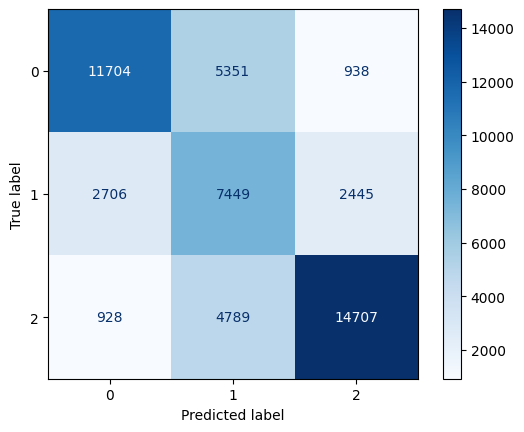

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the class probabilities for the test set
predictions = cnn_model.predict(test_padded, verbose=2)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()
